# **HOTEL BOOKING DEMAND** #

## Business Problem Understanding

**Context**  
Sebuah hotel merekrut Data Scientist yang mempunyai kemampuan dibidang Machine Learning untuk memprediksi apakah seorang customer akan membatalkan booking-an hotel atau tidak. Customer melakukan booking di hotel mereka, akan tetapi hotel sering mengalami kerugian karena customer yang membatalkan pemesanan.
Target :
- 0 : Tidak akan cancel
- 1 : Cancel

**Problem Statement :**

Bagaimana kita dapat memprediksi dan meminimalkan pembatalan oleh customer sehingga dapat mengurangi kerugian dari customer membatalkan kamar.

**Goals :**

Maka berdasarkan permasalahan tersebut, pihak hotel ingin memiliki kemampuan untuk memprediksi kemungkinan calon customer akan melakukan cancel booking pada hotel tersebut atau tidak, sehingga dapat memfokuskan pemberian kamar pada calon customer yang tidak akan men-cancel booking-an kamar mereka.

**Analytic Approach :**

Langkah pertama dalam penyelesaian permasalahan ini adalah melakukan analisis data untuk mengidentifikasi pola-pola yang memisahkan antara pengunjung yang berhasil menginap di hotel dengan yang customer yang memutuskan untuk membatalkan menginap. Setelahnya, kita akan mengembangkan sebuah model klasifikasi yang dapat memberikan prediksi terhadap karakteristik pengunjung, membantu hotel dalam mengantisipasi apakah pengunjung tersebut kemungkinan besar akan menginap atau membatalkan booking-an.

**Metric Evaluation**

1. True Positif: Kita memprediksi customer akan me-cancel dan sebenarnya customer tersebut benar me-cancel
2. False Positif: Kita memprediksi customer akan me-cancel tapi ternyata customer tersebut tidak me-cancel
3. True Negatif: Kita memprediksi customer tidak akan membatalkan booking dan sebenarnya customer benar tidak membatalkan booking
4. False Negatif: Kita memprediksi customer tidak akan membatalkan booking tapi ternyata customer membatalkan booking 

Pada model ini kita akan memprioritaskan untuk meminimalisir customer yang aktualnya cancel namun diprediksi tidak cancel (False Negative), maka dari itu kita akan memaksimalkan score recall pada model.

In [79]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency

# encoding
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder
import category_encoders as ce

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# Load Dataset
This dataset describes two hotel demand datasets. Both hotels are located in Portugal. One of the hotels is a Resort Hotel located at the resort region of Algarve and the other is a City Hotel located at the city of Lisbon. This dataset includes bookings that actually arrived and bookings that were canceled.

Sumber: [hotel booking demand](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)

In [80]:
# Load Data

data = pd.read_csv('data_hotel_booking_demand.csv')
data.head(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
5,ESP,Direct,0,1,No Deposit,0,Transient-Party,A,0,1,0
6,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
8,UMI,Online TA,0,0,No Deposit,0,Transient,E,0,1,1
9,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


Hotel Booking Demand
Context
This data set contains booking information for a hotel located in Portugal, and includes information regarding room reservation for respective customers.
All personally identifying information has been removed from the data.

Attribute Information:
-	country: Country of origin.
-	market_segment: Market segment designation. 
-	previous_cancellations: Number of previous bookings that were cancelled by the customer prior to the current booking.
-	booking_changes: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
-	deposit_type: Indication on if the customer made a deposit to guarantee the booking. 
-	days_in_waiting_list: Number of days the booking was in the waiting list before it was confirmed to the customer.
-	customer_type: Type of booking.
-	reserved_room_type: Code of room type reserved. Code is presented instead of designation for anonymity reasons.
-	required_car_parking_space: Number of car parking spaces required by the customer.
-	total_of_special_request: Number of special requests made by the customer (e.g. twin bed or high floor).
-	is_canceled: Value indicating if the booking was canceled (1) or not (0).


In [82]:
# Extract General Information (tipe data, missing value, %missing value, unique, sample unique)

list_item = []
for i in data.columns :
    list_item.append([i,
                    data[i].dtype,
                    data[i].isna().sum(),
                    round(data[i].isna().sum()/len(data)*100,2),
                    data[i].nunique(),
                    data[i].unique()[:5]
        ])

info_data = pd.DataFrame(list_item, columns='Nama Kolom, tipe data, missing value, % missing value, unique, sample unique'.split(', '))


info_data

,Nama Kolom,tipe data,missing value,% missing value,unique,sample unique
0,country,object,351,0.42,162,"[IRL, FRA, PRT, NLD, ESP]"
1,market_segment,object,0,0.00,8,"[Offline TA/TO, Online TA, Direct, Groups, Cor..."
2,previous_cancellations,int64,0,0.00,15,"[0, 1, 25, 2, 3]"
3,booking_changes,int64,0,0.00,19,"[0, 1, 2, 5, 3]"
4,deposit_type,object,0,0.00,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,int64,0,0.00,115,"[0, 3, 39, 87, 77]"
6,customer_type,object,0,0.00,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,object,0,0.00,10,"[A, E, D, F, B]"
8,required_car_parking_spaces,int64,0,0.00,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,int64,0,0.00,6,"[0, 2, 1, 3, 4]"


Terdapat data missing value pada kolom country dengan jumlah 351 data, setara dengan 0.42% dari total data di dataset. 
Untuk missing value pada kolom country diisi dengan 'Other'.

In [83]:
# Fill missing values in the 'country' column with 'Other'
data['country'] = data['country'].fillna('Other')

In [84]:
missing = data.isnull().sum().sort_values(ascending=False)
percentage = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([missing, percentage], axis=1, keys=['Total', 'Percentage'])
missing_data

,Total,Percentage
country,0,0.0
market_segment,0,0.0
previous_cancellations,0,0.0
booking_changes,0,0.0
deposit_type,0,0.0
days_in_waiting_list,0,0.0
customer_type,0,0.0
reserved_room_type,0,0.0
required_car_parking_spaces,0,0.0
total_of_special_requests,0,0.0


In [85]:
# List to store the result for each column
results = []

for col in data.columns:
    # Get the value counts as a DataFrame
    value_counts = data[col].value_counts().reset_index()
    value_counts.columns = [f'{col}_Value', 'Count']
    
    # Add a column for the number of unique values
    value_counts['Unique_Count'] = len(value_counts)
    
    # Display the DataFrame for the current column
    print(f"DataFrame for column: {col}")
    display(value_counts)
    print("\n")

DataFrame for column: country


,country_Value,Count,Unique_Count
0,PRT,34097,163
1,GBR,8495,163
2,FRA,7307,163
3,ESP,5996,163
4,DEU,5116,163
...,...,...,...
158,DMA,1,163
159,KIR,1,163
160,MYT,1,163
161,KNA,1,163




DataFrame for column: market_segment


,market_segment_Value,Count,Unique_Count
0,Online TA,39460,8
1,Offline TA/TO,17025,8
2,Groups,13721,8
3,Direct,8898,8
4,Corporate,3792,8
5,Complementary,511,8
6,Aviation,165,8
7,Undefined,1,8




DataFrame for column: previous_cancellations


,previous_cancellations_Value,Count,Unique_Count
0,0,79060,15
1,1,4207,15
2,2,86,15
3,3,46,15
4,24,33,15
5,11,28,15
6,6,19,15
7,4,19,15
8,26,18,15
9,25,17,15




DataFrame for column: booking_changes


,booking_changes_Value,Count,Unique_Count
0,0,70873,19
1,1,8963,19
2,2,2652,19
3,3,639,19
4,4,260,19
5,5,90,19
6,6,39,19
7,7,23,19
8,8,10,19
9,10,5,19




DataFrame for column: deposit_type


,deposit_type_Value,Count,Unique_Count
0,No Deposit,73352,3
1,Non Refund,10111,3
2,Refundable,110,3




DataFrame for column: days_in_waiting_list


,days_in_waiting_list_Value,Count,Unique_Count
0,0,80988,115
1,39,166,115
2,58,104,115
3,44,93,115
4,31,93,115
...,...,...,...
110,74,1,115
111,121,1,115
112,36,1,115
113,64,1,115




DataFrame for column: customer_type


,customer_type_Value,Count,Unique_Count
0,Transient,62732,4
1,Transient-Party,17536,4
2,Contract,2882,4
3,Group,423,4




DataFrame for column: reserved_room_type


,reserved_room_type_Value,Count,Unique_Count
0,A,60041,10
1,D,13526,10
2,E,4649,10
3,F,2037,10
4,G,1447,10
5,B,787,10
6,C,673,10
7,H,401,10
8,P,9,10
9,L,3,10




DataFrame for column: required_car_parking_spaces


,required_car_parking_spaces_Value,Count,Unique_Count
0,0,78346,5
1,1,5202,5
2,2,22,5
3,8,2,5
4,3,1,5




DataFrame for column: total_of_special_requests


,total_of_special_requests_Value,Count,Unique_Count
0,0,49188,6
1,1,23214,6
2,2,9120,6
3,3,1784,6
4,4,236,6
5,5,31,6




DataFrame for column: is_canceled


,is_canceled_Value,Count,Unique_Count
0,0,52795,2
1,1,30778,2


# Cleaning data

Pada kolom market_segment terdapat Undefined 1 baris, sehingga diputuskan untuk menghapus baris tersebut.

In [86]:
data = data[~(data['market_segment']=='Undefined')].reset_index(drop=True)

Kolom country ada beberapa kode negara yang memiliki jumlah sedikit (<=5), lebih baik digabung ke Other saja
Kolom reserved_room_type ada tipe P dan L yang memiliki jumlah sedikit (<10) lebih baik digabung ke Other saja

In [87]:
# Index dari country yang memiliki data sedikit (<=5)

country = data['country'].value_counts()
list_country_drop = country[country<=5].index
list_country_drop

Index(['BOL', 'VNM', 'JAM', 'BHR', 'CUB', 'TZA', 'FRO', 'LKA', 'GAB', 'CIV',
       'CAF', 'PRY', 'SYR', 'KEN', 'ZWE', 'GHA', 'GTM', 'ETH', 'MUS', 'TGO',
       'UZB', 'TMP', 'SUR', 'IMN', 'MWI', 'KHM', 'ABW', 'LIE', 'BRB', 'SLV',
       'MNE', 'GGY', 'COM', 'LAO', 'UMI', 'ATA', 'GLP', 'BEN', 'LCA', 'ZMB',
       'RWA', 'SYC', 'SLE', 'NIC', 'BWA', 'NCL', 'CYM', 'SDN', 'MMR', 'MLI',
       'BFA', 'PLW', 'BDI', 'UGA', 'VGB', 'DMA', 'KIR', 'MYT', 'KNA', 'AIA'],
      dtype='object', name='country')

In [88]:
data['country'] = pd.Series(np.where(data['country'].isin(list_country_drop), 'Other', data['country']))

In [89]:
data.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


# Exploratory data analysis (EDA)

In [90]:
num_feature = data.describe().columns
num_feature = num_feature.drop('is_canceled')
num_feature

Index(['previous_cancellations', 'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

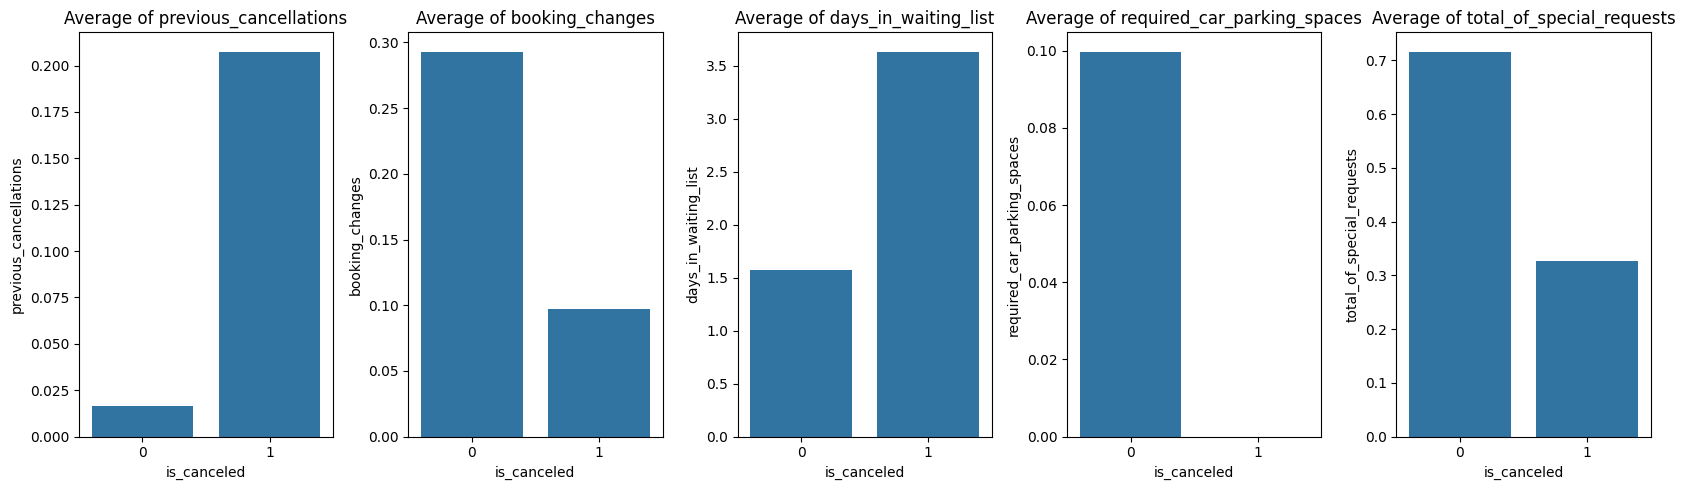

In [91]:
plt.figure(figsize=(20,5))

for col in range(len(num_feature)):

    plt.subplot(1,6, col+1)
    sns.barplot(data=data, x='is_canceled', y=num_feature[col], ci=0)  # default barplot adalah average
    plt.title('Average of ' + num_feature[col])

plt.tight_layout()

Berikut adalah penjelasan dari barplot di atas, terkait dengan faktor-faktor yang berhubungan dengan pembatalan (diwakili oleh is_canceled di mana 0 berarti tidak dibatalkan dan 1 berarti dibatalkan) :
- previous_cancellations : Pelanggan yang sebelumnya telah membatalkan pemesanan lebih cenderung untuk membatalkan lagi, seperti yang ditunjukkan oleh rata-rata yang lebih tinggi untuk canceled

- booking_changes : Pelanggan yang melakukan perubahan pada pemesanan mereka lebih cenderung untuk membatalkan, meskipun perbedaannya tidak terlalu mencolok seperti pada pembatalan sebelumnya.

- days_in_waiting_list : Jumlah hari rata-rata yang lebih lama di daftar tunggu berkaitan dengan kemungkinan pembatalan yang lebih tinggi. Pelanggan dengan periode menunggu yang lebih lama cenderung lebih sering membatalkan.

- required_car_parking_spaces : Kebutuhan akan ruang parkir tampaknya memiliki dampak minimal terhadap pembatalan. Namun, ada sedikit indikasi bahwa mereka yang tidak membutuhkan parkir lebih mungkin untuk membatalkan.

- total_of_special_requests : Pelanggan dengan lebih banyak permintaan khusus cenderung lebih kecil kemungkinannya untuk membatalkan. Rata-rata jumlah permintaan khusus lebih tinggi bagi mereka yang tidak membatalkan.

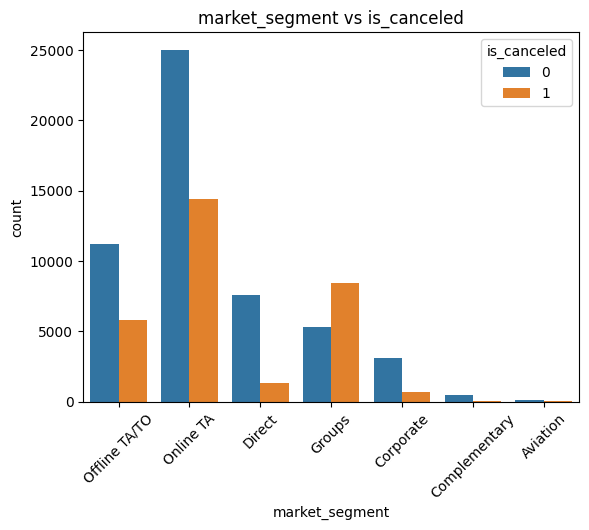

In [92]:
# Market segment vs is_canceled
sns.countplot(data= data, x= 'market_segment', hue= 'is_canceled')
plt.title('market_segment vs is_canceled')
plt.xticks(rotation= 45)
plt.show()


- Market Segment "Online TA": Segmen "Online TA" (Travel Agency) memiliki jumlah pembatalan tertinggi dibandingkan segmen lainnya. Ini menunjukkan bahwa pelanggan yang memesan melalui agen perjalanan online lebih cenderung membatalkan reservasi mereka.

- Market Segment "Groups": Segmen "Groups" juga memiliki jumlah pembatalan yang signifikan, namun tidak sebanyak "Online TA". Hal ini mungkin menunjukkan bahwa pemesanan grup cenderung lebih stabil dibandingkan pemesanan individu melalui agen online.

- Market Segment "Offline TA/TO": Meskipun segmen "Offline TA/TO" memiliki jumlah pemesanan yang besar, jumlah pembatalannya relatif lebih rendah dibandingkan "Online TA". Ini menunjukkan bahwa pemesanan melalui agen perjalanan offline mungkin lebih cenderung untuk dipertahankan daripada yang dilakukan secara online.

- Market Segments "Direct", "Corporate", "Complementary", dan "Aviation": Segmen-segmen ini memiliki jumlah pembatalan yang relatif lebih rendah, menunjukkan bahwa pelanggan dalam segmen ini cenderung lebih berkomitmen terhadap pemesanan mereka.

Secara keseluruhan, segmen "Online TA" menunjukkan tingkat pembatalan yang paling tinggi, yang dapat menjadi indikasi bahwa pemesanan melalui platform online mungkin lebih rentan terhadap perubahan atau pembatalan.


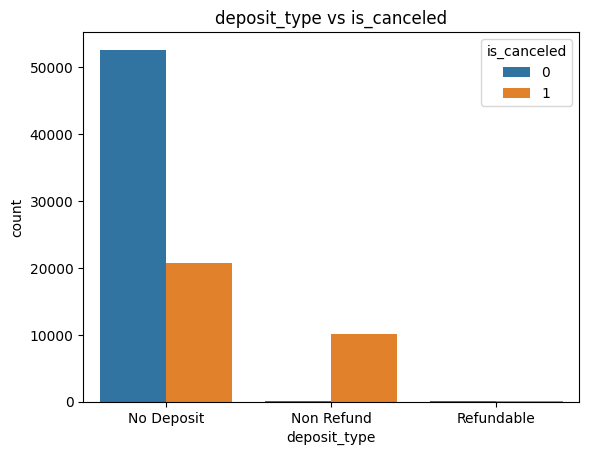

In [93]:
# deposit_type vs is_canceled

sns.countplot(data= data, x= 'deposit_type', hue= 'is_canceled')
plt.title('deposit_type vs is_canceled')
plt.xticks(rotation= 0)
plt.show()

- No Deposit: Mayoritas pemesanan yang tidak memerlukan deposit ("No Deposit") memiliki jumlah pembatalan yang tinggi. Ini menunjukkan bahwa ketika pelanggan tidak diwajibkan untuk memberikan deposit, mereka cenderung lebih mudah membatalkan reservasi.

- Non Refund: Tipe deposit "Non Refund" (Tidak Dapat Dikembalikan) menunjukkan jumlah pembatalan yang lebih rendah dibandingkan "No Deposit". Ini mungkin disebabkan oleh fakta bahwa pelanggan yang telah membayar deposit yang tidak dapat dikembalikan cenderung mempertahankan reservasi mereka untuk menghindari kerugian finansial.

- Refundable: Tipe deposit "Refundable" memiliki jumlah pembatalan yang sangat rendah, hampir tidak terlihat di grafik. Hal ini menunjukkan bahwa jika deposit bisa dikembalikan, pelanggan cenderung untuk tetap pada pemesanan mereka, atau tidak terlalu sering memilih opsi ini.

Secara keseluruhan, data menunjukkan bahwa kebijakan deposit memainkan peran penting dalam keputusan pelanggan untuk membatalkan reservasi. Kebijakan "No Deposit" berhubungan dengan tingkat pembatalan yang lebih tinggi, sedangkan kebijakan "Non Refund" atau "Refundable" tampaknya mengurangi kemungkinan pembatalan.

In [94]:
data.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


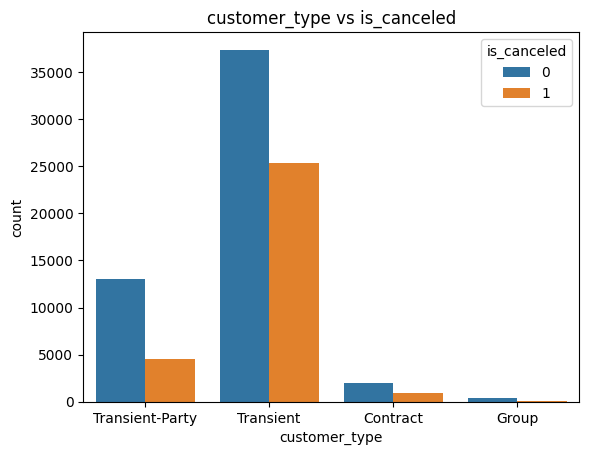

In [95]:
# Customer Type vs is_canceled

sns.countplot(data= data, x= 'customer_type', hue= 'is_canceled')
plt.title('customer_type vs is_canceled')
plt.xticks(rotation= 0)
plt.show()

Tipe Customer:
- Transient: Pelanggan dengan tipe "Transient" memiliki jumlah pembatalan tertinggi dibandingkan dengan tipe pelanggan lainnya. Ini menunjukkan bahwa pelanggan yang tidak berkomitmen untuk jangka panjang dan hanya menginap untuk satu atau beberapa malam cenderung lebih sering membatalkan reservasi mereka.

- Transient-Party: Tipe ini juga memiliki jumlah pembatalan, tetapi tidak sebanyak tipe "Transient". Hal ini mungkin menunjukkan bahwa meskipun mereka tidak menginap lama, mereka lebih terikat karena faktor kelompok.

- Contract dan Group: Pelanggan dengan tipe "Contract" dan "Group" menunjukkan jumlah pembatalan yang paling sedikit. Ini bisa disebabkan oleh komitmen jangka panjang atau ketergantungan pada rencana yang lebih solid, seperti perjanjian kontrak atau pemesanan kelompok.

Secara keseluruhan, tipe pelanggan "Transient" tampaknya lebih tidak stabil dan lebih mungkin membatalkan dibandingkan dengan tipe pelanggan lainnya.

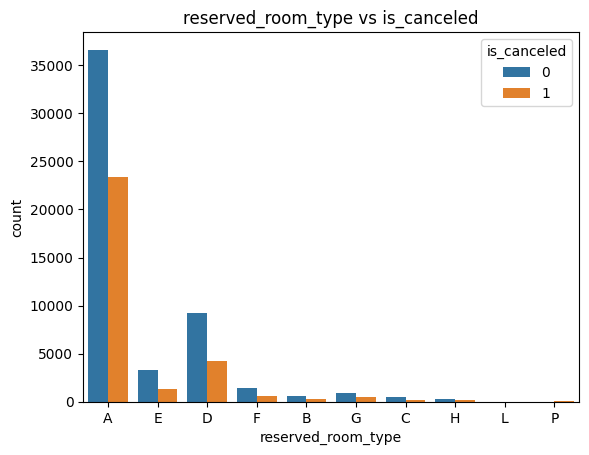

In [96]:
# reserved_room_type vs is_canceled

sns.countplot(data=data, x= 'reserved_room_type', hue= 'is_canceled')
plt.title('reserved_room_type vs is_canceled')
plt.xticks(rotation= 0)
plt.show()

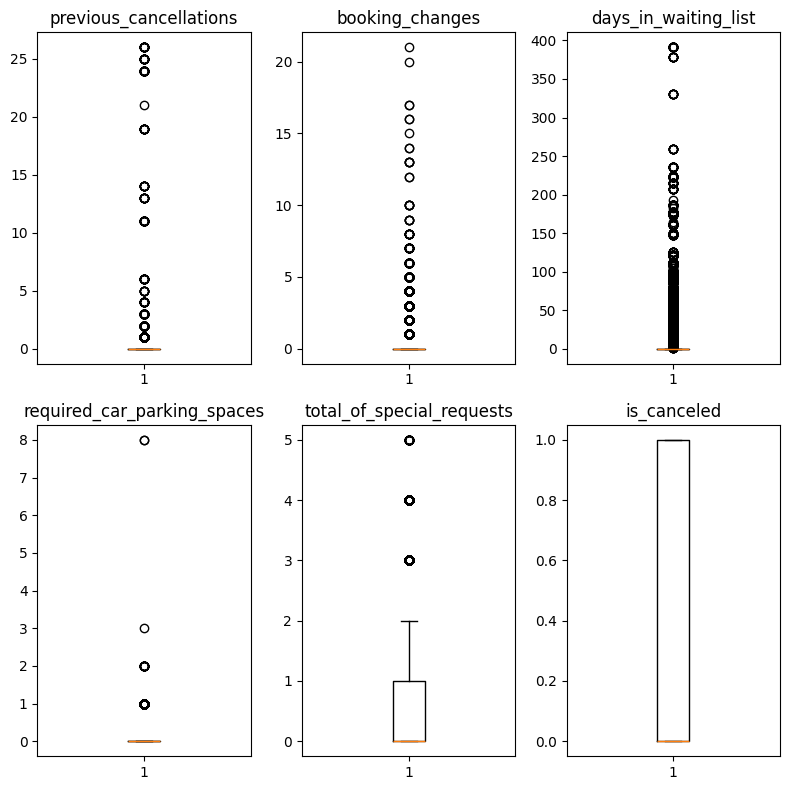

In [97]:
# Cek Outliers (boxplot)

number_col = data.select_dtypes(include=['float64','int64']).columns
num_col = len(number_col)

num_row = (num_col//3) + (num_col % 3 > 0)


plt.figure(figsize=[8,8])

for i, column in enumerate(number_col,1):
    plt.subplot(num_row,3,i)
    plt.boxplot(data[column].dropna())
    plt.title(column)

plt.tight_layout()
plt.show()

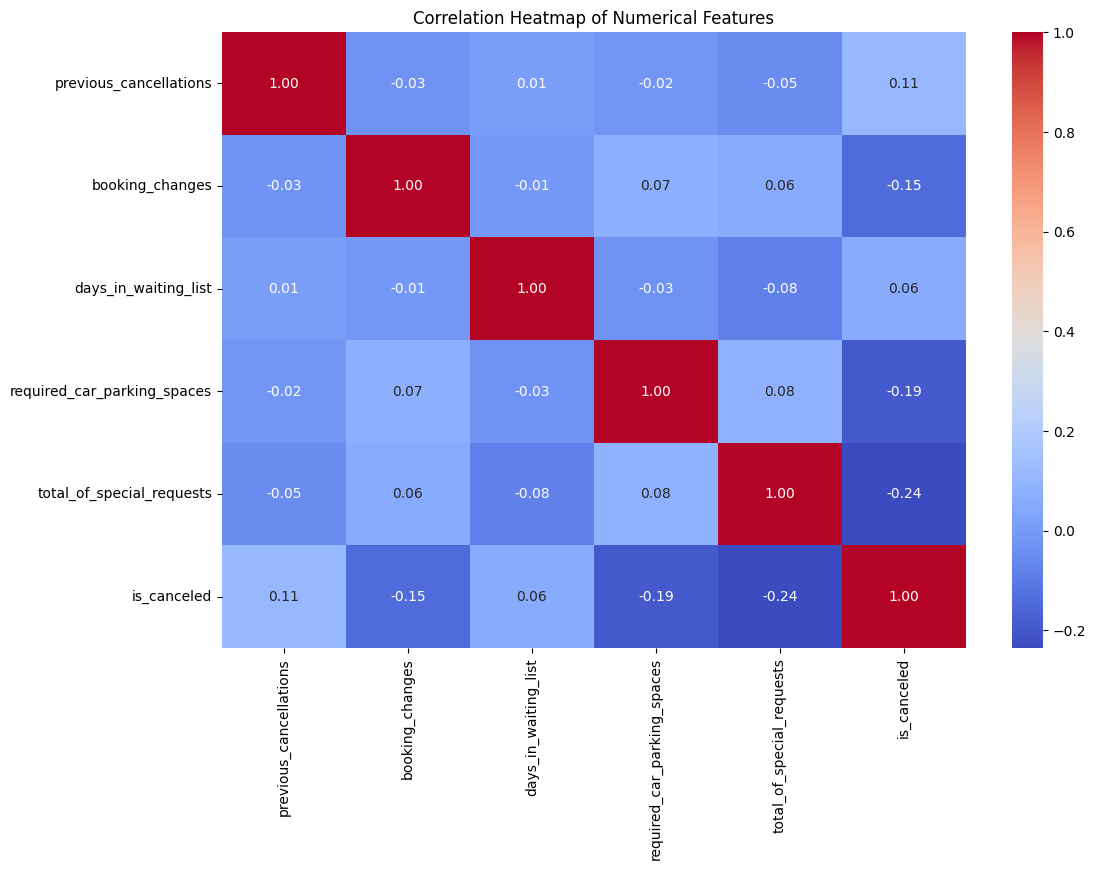

In [98]:
# Select numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation matrix
correlation_matrix = data[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Secara keseluruhan, fitur total_of_special_requests dan required_car_parking_spaces menunjukkan korelasi negatif yang lebih kuat terhadap pembatalan, menunjukkan bahwa pelanggan yang lebih terlibat dalam perencanaan (dengan permintaan khusus atau kebutuhan parkir) cenderung lebih sedikit membatalkan pemesanan. Sebaliknya, fitur previous_cancellations menunjukkan korelasi positif, yang menandakan bahwa riwayat pembatalan sebelumnya dapat menjadi indikator risiko pembatalan di masa depan.

#

In [99]:
# Feature Selection Categorical Chi Square Test p value < 0.5

hasil = []

for i in data.select_dtypes(include=['object']):
    contigency_table = pd.crosstab(data[i], data['is_canceled'])
    stat, pval, df, expected_freq = chi2_contingency(contigency_table)
    berpengaruh = pval < 0.05
    hasil.append([i, stat, pval, berpengaruh])

pd.DataFrame(hasil, columns=['Feature', 'Chi Square Stats', 'P-Value', 'Berpengaruh?'])

,Feature,Chi Square Stats,P-Value,Berpengaruh?
0,country,10683.642740,0.000000e+00,True
1,market_segment,6093.669635,0.000000e+00,True
2,deposit_type,19346.919926,0.000000e+00,True
3,customer_type,1485.219101,0.000000e+00,True
4,reserved_room_type,476.203363,7.131516e-97,True


# Data Preparation

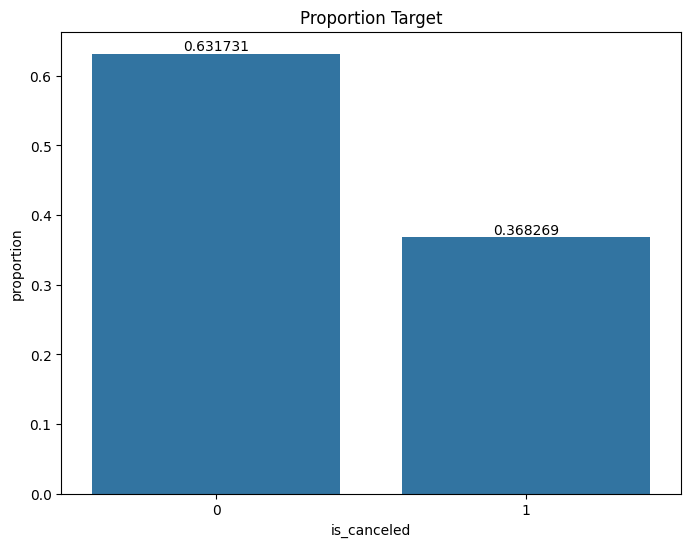

In [100]:
# Cek Balance Target
pct = data['is_canceled'].value_counts(normalize=True).to_frame().reset_index()


plt.figure(figsize=(8, 6))
plt.title('Proportion Target')
ax = sns.barplot(pct, x= 'is_canceled', y= 'proportion')
ax.bar_label(ax.containers[0])
plt.show()

Proporsi target cukup imbalance, maka dari itu tidak diperlukan imbalance dataset.

In [101]:
data.head(5)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [148]:
# Memilih fitur dan target
X = data.drop(['is_canceled'], axis=1)
y = data['is_canceled']

In [103]:
# Membagi data menjadi set pelatihan dan set pengujian
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=24)

In [104]:
pipe_poly_scaling = Pipeline([
    ('poly',PolynomialFeatures(degree=1)),
    ('scaling',RobustScaler())
])

# Transformer scheme
transformer = ColumnTransformer([
    ('pipe_poly_scaling', pipe_poly_scaling, ['previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']),
    ('onehot', OneHotEncoder(drop='first'), ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
    ('binary', ce.BinaryEncoder(), ['country'])
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_poly_scaling',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=1)),
                                                 ('scaling', RobustScaler())]),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type']),
                                ('binary', BinaryEncoder(), ['country'])])

## Modeling & Evaluation

In [105]:
# Model Benchmark
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
GBoosting = GradientBoostingClassifier(random_state=0)
models = [logreg, knn, dt, rf, GBoosting]

In [106]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
nearmiss = NearMiss()
smote = SMOTE(random_state=0)

In [107]:
# Model Benchmark
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
GBoosting = GradientBoostingClassifier(random_state=0)
models = [logreg, knn, dt, rf, GBoosting]

list_mean = []
list_std = []
list_score = []

for model in models:
    pipe_model=Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])

    model_cv = cross_val_score(
        estimator= pipe_model,
        X= X_train,
        y= y_train,
        cv = 5, 
        scoring= 'recall'
    )

    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())
    list_score.append(model_cv.round(3))

pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'GBoosting'],
    'mean recall' : list_mean,
    'std recall' : list_std,
    'score' : list_score
}).sort_values('mean recall', ascending=False)

,model,mean recall,std recall,score
3,Random Forest,0.696763,0.005350,"[0.697, 0.705, 0.697, 0.697, 0.688]"
2,Decision Tree,0.691727,0.006972,"[0.69, 0.699, 0.699, 0.691, 0.68]"
1,KNN,0.691563,0.011757,"[0.71, 0.68, 0.677, 0.694, 0.696]"
4,GBoosting,0.605662,0.003304,"[0.603, 0.61, 0.602, 0.604, 0.609]"
0,Logistic Regression,0.551684,0.006354,"[0.542, 0.556, 0.554, 0.559, 0.548]"


best model

Model RandomForestClassifier dan DecisionTreeClassifier dipilih menjadi 2 model paling optimal karna memiliki nilai mean paling tinggi dan paling stabil karna memiliki standar deviasi yang kecil. Selanjutnya akan dilakukan hyperparameter tuning untuk kedua model ini.

### Hyperparameter Tuning
`RandomForestClassifier`

In [108]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
nearmiss = NearMiss()
smote = SMOTE(random_state=0)

In [109]:
criterion = ["gini", "entropy", "log_loss"]
n_estimators = list(np.arange(1,100,1))          # jumlah pohon
max_features = list(np.arange(1,len(X.columns),1))            # jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)
max_depth = list(np.arange(3,100,2))               # kedalaman pohon
min_samples_leaf = list(np.arange(1,50,1))
min_samples_split = list(np.arange(1,100,2))

# Hyperparameter space RandomForestClassifier
hyperparam_space_rf = {
    'resampler':[smote, rus, ros, nearmiss, None],
    'model__criterion': criterion,
    'model__n_estimators': n_estimators,
    'model__max_features':max_features,
    'model__max_depth':max_depth,
    'model__min_samples_leaf':min_samples_leaf,
    'model__min_samples_split': min_samples_split,
    'model__random_state':[0]
}

# Benchmark model 1
dtc = rf

# Create the algorithm chains
estimator_rf = Pipeline([
    ('tansformer', transformer),
    ('resampler', rus), 
    ('model', rf)
    ])

# Hyperparameter tuning
random_rf = RandomizedSearchCV(
    estimator = estimator_rf, 
    param_distributions = hyperparam_space_rf, 
    cv = 5, 
    scoring = 'recall', 
    n_jobs = -1, 
    random_state=0,
    n_iter=500
)

In [110]:
# fitting 
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_poly_scaling',
                                                                               Pipeline(steps=[('poly',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requests'])...
                                                                np.int64(18),
                                                                np.int64(19),
                                                                np.int64(20),
                                                                np.int64(21),
                                                                np.int64(22),
                                                                np.int64(23),
                                                                np.int64(24),
                                                                np.int64(25),
                                                                np.int64(26),
                                                                np.int64(27),
                                                                np.int64(28),
                                                                np.int64(29),
                                                                np.int64(30), ...],
                                        'model__random_state': [0],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      NearMiss(), None]},
                   random_state=0, scoring='recall')

In [111]:
pd.DataFrame(random_rf.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler,param_model__random_state,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,...,param_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
390,11.733706,0.792738,0.253028,0.038991,None,0,82,3,5,9,...,gini,"{'resampler': None, 'model__random_state': 0, ...",0.685279,0.695370,0.690292,0.688871,0.669578,0.685878,0.008770,1
146,2.426329,0.281172,0.082464,0.008562,None,0,16,79,7,9,...,entropy,"{'resampler': None, 'model__random_state': 0, ...",0.681015,0.692120,0.683591,0.662470,0.663079,0.676455,0.011761,2
230,11.703887,1.339524,0.183159,0.025447,None,0,91,29,19,9,...,log_loss,"{'resampler': None, 'model__random_state': 0, ...",0.683655,0.665719,0.681763,0.685621,0.663891,0.676130,0.009345,3
268,10.553300,1.504705,0.189770,0.021250,None,0,88,63,11,8,...,gini,"{'resampler': None, 'model__random_state': 0, ...",0.685279,0.668156,0.680747,0.661048,0.663688,0.671784,0.009554,4
306,12.827627,1.306035,0.290296,0.093265,None,0,99,67,7,7,...,entropy,"{'resampler': None, 'model__random_state': 0, ...",0.683858,0.666328,0.682778,0.663079,0.662470,0.671703,0.009580,5


In [112]:
# menampilkan best score dan best parameter dari randomforest classifier setelah tuning pertama
print('RandomForestClassifier')
print('Best_score:', random_rf.best_score_)
print('Best_params:', random_rf.best_params_)

RandomForestClassifier
Best_score: 0.6858779334204785
Best_params: {'resampler': None, 'model__random_state': 0, 'model__n_estimators': np.int64(82), 'model__min_samples_split': np.int64(3), 'model__min_samples_leaf': np.int64(5), 'model__max_features': np.int64(9), 'model__max_depth': np.int64(45), 'model__criterion': 'gini'}


### Hyperparameter Tuning ke-2
`RandomForestClassifier`

In [115]:
criterion = ["entropy", "log_loss"]
n_estimators = list(np.arange(1,100,2))          # jumlah pohon
max_features = list(np.arange(1,len(X.columns),1))            # jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)
max_depth = list(np.arange(25,100,2))               # kedalaman pohon
min_samples_leaf = list(np.arange(1,20,1))
min_samples_split = list(np.arange(10,80,2) )

# Hyperparameter space RandomForestClassifier
hyperparam_space_rf = {
    'resampler':[smote, rus, ros, None],
    'model__criterion': criterion,
    'model__n_estimators': n_estimators,
    'model__max_features':max_features,
    'model__max_depth':max_depth,
    'model__min_samples_leaf':min_samples_leaf,
    'model__min_samples_split': min_samples_split,
    'model__random_state':[0]
}

# Benchmark model 1
dtc = rf

# Create the algorithm chains
estimator_rf = Pipeline([
    ('tansformer', transformer),
    ('resampler', rus), 
    ('model', rf)
    ])

# Hyperparameter tuning
random_rf_2 = RandomizedSearchCV(
    estimator = estimator_rf, 
    param_distributions = hyperparam_space_rf, 
    cv = 5, 
    scoring = 'recall', 
    n_jobs = -1, 
    random_state=0,
    n_iter=500
)

In [116]:
# fitting the randomsearch for DecisionTreeClassifier best params setelah tuning 2 kali ke X_train, y_trainc
random_rf_2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_poly_scaling',
                                                                               Pipeline(steps=[('poly',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requests'])...
                                                                np.int64(33),
                                                                np.int64(35),
                                                                np.int64(37),
                                                                np.int64(39),
                                                                np.int64(41),
                                                                np.int64(43),
                                                                np.int64(45),
                                                                np.int64(47),
                                                                np.int64(49),
                                                                np.int64(51),
                                                                np.int64(53),
                                                                np.int64(55),
                                                                np.int64(57),
                                                                np.int64(59), ...],
                                        'model__random_state': [0],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      None]},
                   random_state=0, scoring='recall')

In [ ]:
print('RandomForestClassifier')
print('Best_score:', random_rf_2.best_score_)
print('Best_params:', random_rf_2.best_params_)

RandomForestClassifier
Best_score: 0.6996059412717983
Best_params: {'model__random_state': 0, 'model__n_estimators': np.int64(15), 'model__min_samples_split': np.int64(42), 'model__min_samples_leaf': np.int64(1), 'model__max_features': np.int64(9), 'model__max_depth': np.int64(43), 'model__criterion': 'entropy'}


## Predict to Test Set

In [153]:
model = Pipeline([
    ('transformer', transformer),
    ('model', rf)
])

# fitting
model.fit(X_train, y_train)

# predict
y_pred_before = model.predict(X_test)

# recall score
score_before = recall_score(y_test, y_pred_before)
score_before

np.float64(0.7028914879792073)

In [ ]:
y_pred_before_all = model.predict(X)

In [ ]:
# best model
rf_tuning = random_rf.best_estimator_

# fitting
rf_tuning.fit(X_train, y_train)

# predict
y_pred_rf_tuning = rf_tuning.predict(X_test)

# recall score
recall_rf_tuning = recall_score(y_test, y_pred_rf_tuning)
recall_rf_tuning

np.float64(0.685672514619883)

In [118]:
# best model
rf_tuning2 = random_rf_2.best_estimator_

# fitting
rf_tuning2.fit(X_train, y_train)

# predict
y_pred_rf_tuning2 = rf_tuning2.predict(X_test)

# recall score
recall_rf_tuning2 = recall_score(y_test, y_pred_rf_tuning2)
recall_rf_tuning2

np.float64(0.685672514619883)

In [119]:
score_beforeafter_tuning = pd.DataFrame({
    'Model': ['RandomForestClassifier'],
    'Before tuning': [score_before],
    'Recall score tuning 1': [recall_rf_tuning],
    'Recall score tuning 2': [recall_rf_tuning2]
})

# Menampilkan DataFrame
score_beforeafter_tuning

,Model,Before tuning,Recall score tuning 1,Recall score tuning 2
0,RandomForestClassifier,0.702891,0.685673,0.685673


Tuning pertama untuk algorithm DecisionTreeClassifier

In [128]:
criterion = ["gini", "entropy", "log_loss"]
max_depth = list(np.arange(3,50,1))               # kedalaman pohon
min_samples_leaf = list(np.arange(2,100,2))
min_samples_split = list(np.arange(2,100,2) )
max_features = list(np.arange(1,len(X.columns),1))            # jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)

# Hyperparameter space DecisionTreeClassifier
hyperparam_space_dtc = {
    'resampler':[smote, rus, ros, nearmiss, None],
    'model__criterion': criterion,
    'model__max_depth':max_depth,
    'model__min_samples_leaf':min_samples_leaf,
    'model__min_samples_split': min_samples_split,
    'model__max_features':max_features,
    'model__random_state':[0]
}

# Benchmark model 1
dtc = dt

# Create the algorithm chains
estimator_dtc = Pipeline([
    ('tansformer', transformer),
    ('resampler', rus), 
    ('model', dtc)
    ])

# Hyperparameter tuning
random_dtc = RandomizedSearchCV(    # karna jumlah data yang sangat banyak (83.573) saya memutuskan menggunakan randomizedsearch 
    estimator = estimator_dtc, 
    param_distributions = hyperparam_space_dtc, 
    cv = 5, 
    scoring = 'recall', 
    n_jobs = -1, 
    random_state=0,
    n_iter=500
)

In [129]:
# fitting the randomsearch for DecisionTreeClassifier best params ke X_train, y_train
random_dtc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_poly_scaling',
                                                                               Pipeline(steps=[('poly',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requests'])...
                                                                     np.int64(36),
                                                                     np.int64(38),
                                                                     np.int64(40),
                                                                     np.int64(42),
                                                                     np.int64(44),
                                                                     np.int64(46),
                                                                     np.int64(48),
                                                                     np.int64(50),
                                                                     np.int64(52),
                                                                     np.int64(54),
                                                                     np.int64(56),
                                                                     np.int64(58),
                                                                     np.int64(60), ...],
                                        'model__random_state': [0],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      NearMiss(), None]},
                   random_state=0, scoring='recall')

In [130]:
# menampilkan best score untuk DecisionTreeClassifier setelah tuning 1
print('DecisionTreeClassifier')
print('Best_score:', random_dtc.best_score_)
print('Best_params:', random_dtc.best_params_)

DecisionTreeClassifier
Best_score: 0.6883163042716293
Best_params: {'resampler': None, 'model__random_state': 0, 'model__min_samples_split': np.int64(88), 'model__min_samples_leaf': np.int64(12), 'model__max_features': np.int64(7), 'model__max_depth': np.int64(19), 'model__criterion': 'gini'}


In [131]:
criterion = ["gini"]
max_depth = list(np.arange(3,20,1))               # kedalaman pohon
min_samples_leaf = list(np.arange(60,100,1))
min_samples_split = list(np.arange(30,100,1) )
max_features = list(np.arange(1,len(X.columns),1))            # jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)

# Hyperparameter space DecisionTreeClassifier
hyperparam_space_dtc = {
    'resampler':[smote, rus, ros, nearmiss, None],
    'model__criterion': criterion,
    'model__max_depth':max_depth,
    'model__min_samples_leaf':min_samples_leaf,
    'model__min_samples_split': min_samples_split,
    'model__max_features':max_features,
    'model__random_state':[0]
}

# Benchmark model 1
dtc = dt

# Create the algorithm chains
estimator_dtc = Pipeline([
    ('tansformer', transformer),
    ('resampler', rus), 
    ('model', dtc)
    ])

# Hyperparameter tuning
random_dtc_2 = RandomizedSearchCV(
    estimator = estimator_dtc, 
    param_distributions = hyperparam_space_dtc, 
    cv = 5, 
    scoring = 'recall', 
    n_jobs = -1, 
    random_state=0,
    n_iter=500
)

In [132]:
# fitting the randomsearch for DecisionTreeClassifier best params setelah tuning 2 kali ke X_train, y_train
random_dtc_2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_poly_scaling',
                                                                               Pipeline(steps=[('poly',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requests'])...
                                                                     np.int64(47),
                                                                     np.int64(48),
                                                                     np.int64(49),
                                                                     np.int64(50),
                                                                     np.int64(51),
                                                                     np.int64(52),
                                                                     np.int64(53),
                                                                     np.int64(54),
                                                                     np.int64(55),
                                                                     np.int64(56),
                                                                     np.int64(57),
                                                                     np.int64(58),
                                                                     np.int64(59), ...],
                                        'model__random_state': [0],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      NearMiss(), None]},
                   random_state=0, scoring='recall')

In [139]:
# best model
dtc_tuning = random_dtc.best_estimator_

# fitting
dtc_tuning.fit(X_train, y_train)

# predict
y_pred_dtc_tuning = dtc_tuning.predict(X_test)

# recall score
recall_dtc_tuning = recall_score(y_test, y_pred_dtc_tuning)
recall_dtc_tuning

np.float64(0.6697530864197531)

In [134]:
# best model
dtc_tuning2 = random_dtc_2.best_estimator_

# fitting
dtc_tuning2.fit(X_train, y_train)

# predict
y_pred_dtc_tuning2 = dtc_tuning2.predict(X_test)

# recall score
recall_dtc_tuning2 = recall_score(y_test, y_pred_dtc_tuning2)
recall_dtc_tuning2

np.float64(0.6336907082521117)

In [135]:
y_pred_dtc_all = dtc_tuning.predict(X)
y_pred_dtc_all

array([0, 0, 0, ..., 0, 0, 1])

In [136]:
score_beforeafter_tuning = pd.DataFrame({
    'Model': ['DecisionTreeClassifier'],
    'Before tuning': [score_before],
    'Recall score tuning 1': [recall_dtc_tuning],
    'Recall score tuning 2': [recall_dtc_tuning2]
})

# Menampilkan DataFrame
score_beforeafter_tuning

,Model,Before tuning,Recall score tuning 1,Recall score tuning 2
0,DecisionTreeClassifier,0.702891,0.669753,0.633691


Model yang paling baik yaitu Random Forest Classifier
- Random Forest before hyperparameter tuning Recall score:0.702891
- Random Forest After Hyperparameter tuning Recall score: 0.685673
- Random Forest After second Hyperparameter tuning Recall score: 0.685673
- Decision Tree before hyperparameter tuning recall score: 0.702891
- Decision Tree after hyperparameter tuning Recall score: 0.669753
- Decision Tree after second hyperparameter tuning Recall score: 0.633691


In [144]:
rf_tuning

Pipeline(steps=[('tansformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_poly_scaling',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country'])])),
                ('resampler', None),
                ('model',
                 RandomForestClassifier(max_depth=np.int64(45),
                                        max_features=np.int64(9),
                                        min_samples_leaf=np.int64(5),
                                        min_samples_split=np.int64(3),
                                        n_estimators=np.int64(82),
                                        random_state=0))])

In [145]:
# melihat nilai dari features importance
len(rf_tuning['model'].feature_importances_)
feat_cat = list(transformer.transformers_[0][1][0].get_feature_names_out())
len(feat_cat)
col_robust = list(transformer.transformers_[0][1][1].get_feature_names_out())
len(col_robust)
col_onehot = list(transformer.transformers_[1][1].get_feature_names_out())
len(col_onehot)
col_binary = list(transformer.transformers_[2][2])
len(col_binary)
feat_all = feat_cat + col_robust + col_onehot + col_binary

In [150]:
# data frame feature importance yang telah diurutkan dari nilai importance yang paling tinggi
feat_imp = pd.DataFrame({
    'feature importance' : rf_tuning['model'].feature_importances_
}, index = feat_all).sort_values('feature importance',ascending=False).head(15)

feat_imp

,feature importance
market_segment_Complementary,0.319169
total_of_special_requests,0.095765
previous_cancellations,0.086729
x5,0.078541
reserved_room_type_P,0.059382
required_car_parking_spaces,0.054836
reserved_room_type_L,0.039335
x3,0.038454
booking_changes,0.037267
market_segment_Groups,0.034010


Text(0.5, 1.0, 'Feature Importance')

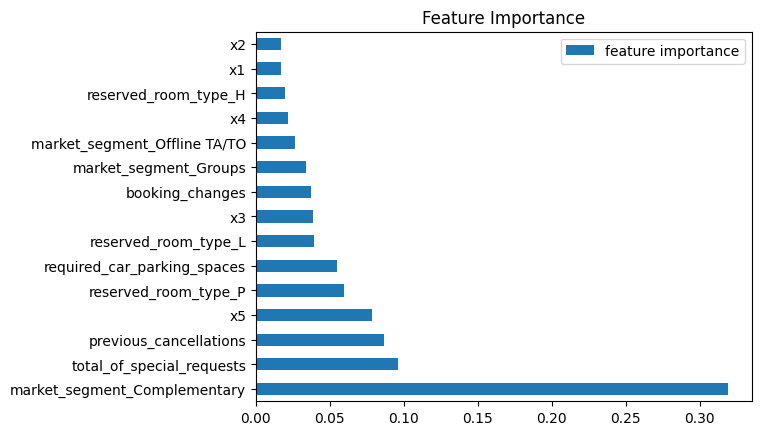

In [151]:
# membuat barplot untuk melakukan visualisasi terhadap feature importance
feat_imp.plot(kind='barh')
plt.title('Feature Importance')

In [ ]:
Ada 3 Features dengan nilai importance tertinggi atau memiliki pengaruh penting terhadap customer dalam melakukan cancel atau tidak berdasarkan feature importance:
- market segment complementary
- total of special requests
- previous cancellations


### Kesimpulan

Berdasarkan hasil classification report dari model kita, kita dapat menyimpulkan/mengambil konklusi bahwa bila seandainya nanti kita menggunakan model kita untuk memfilter/menyaring list customer yang kita coba tawarkan, maka model kita dapat memprediksi 70% custumer benar akan melakukan cancel pada hotel tersebut. 

Model kita ini memiliki ketepatan prediksi kandidat yang akan cancel sebesar 70% (recallnyanya), jadi setiap model kita memprediksi bahwa seorang kandidat itu akan cancel, maka kemungkinan prediksi benar itu sebesar 70% kurang lebih.

### Recomendation

In [ ]:
Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Membuat sistem dimana hotel akan memprediksi customer yang akan melakukan cancel sehingga kamar dari customer yang akan cancel dapat diberikan kepada customer lain yang tidak cancel. 
- menambahkan lebih banyak feature pada modelnya, seperti kepuasan review dari customer yang telah menggunakan layanan hotel.
- Menganalisa data-data model  yang masih salah prediksi untuk mengetahui alasannya dan karakteristiknya bagaimana.

save

In [155]:
#import pickle
#pickle.dump(rf_tuning, open('hotel_booking_model.sav', 'wb'))